*Copyright (C) 2022 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Sigma-Delta Neurons

## Introduction

Many temporal signals are slow and do not change in a shorter time-scale. Nevertheless, in classical ANNs, computation is executed every timestep even if the information is redundant over time. By encoding the temporal signal with a delta-encoder, we can minimize the computational costs without increasing delay.


<table><tr>
<td> <img src="https://upload.wikimedia.org/wikipedia/commons/d/dd/Muybridge_race_horse_animated.gif" alt="Drawing" style="height: 200px;"/> </td>
</tr></table>

__Sigma-delta neural networks__ consists of two main units: _sigma_ decoder in the dendrite and _delta_ encoder in the axon. Delta encoder uses differential encoding on the output activation of a regular ANN activation, for e.g. ReLU. In addition it only sends activation to the next layer when the encoded message magnitude is larger than its threshold. The sigma unit accumulates the sparse event messages and accumulates it to restore the original value.


<table><tr>
<td> <img src="https://raw.githubusercontent.com/lava-nc/lava-dl/main/tutorials/lava/lib/dl/slayer/pilotnet/images/delta_encoder.png" alt="Drawing" style="height: 200px;"/> </td>
<td> <img src="https://raw.githubusercontent.com/lava-nc/lava-dl/main/tutorials/lava/lib/dl/slayer/pilotnet/images/sigma_decoder.png" alt="Drawing" style="height: 200px;"/> </td>
</tr></table>

A sigma-delta neuron is simply a regular activation wrapped around by a sigma unit at it's input and a delta unit at its output.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import urllib
from lava.proc.io.source import RingBuffer as Input
from lava.proc.dense.process import Dense
from lava.proc.sdn.process import SigmaDelta, ActivationMode, Delta
from lava.proc.monitor.process import Monitor
from lava.proc.bit_check.process import BitCheck
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg

## Create input time-series and neuron

In order to demonstrate the capabilities of the sigma-delta neuron and how much computational costs can be saved, we will simulate such a neuron and execute it on a representative time-series. We chose to model this time-series as an sinusoidal with overlapping frequencies and then apply the a standard ReLU function on it.

ANN MACs: 200


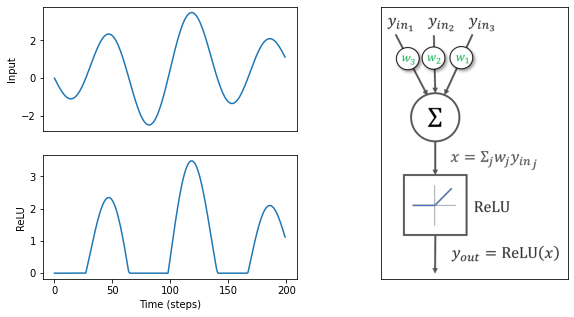

In [2]:
t_sim = 200
vth = 0.5

# Interesting input time-series
time = np.arange(t_sim)
inp_data = np.atleast_2d(np.sin(time / 100 * 2 * np.pi) - 2 * np.sin(time / 100 * 3 * np.pi)) + time / 200

# ReLU of input
relu = np.maximum(inp_data, 0)

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot2grid((2, 2), (0, 0))

ax.set_ylabel("Input")
ax.set_xticks([])

ax.plot(inp_data[0])

ax = plt.subplot2grid((2, 2), (1, 0))
ax.set_ylabel("ReLU")
ax.set_xlabel("Time (steps)")
ax.plot(relu[0]);

ax = plt.subplot2grid((2, 2), (0, 1), rowspan=4)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(PIL.Image.open(urllib.request.urlopen("https://raw.githubusercontent.com/lava-nc/lava-docs/img/sig-delta-neuron/_static/images/tutorial10/relu.png")))

MACs = len(inp_data[0])

print(f"ANN MACs: {MACs}")

For this, and any other time-series, a standard ANN must multiply and accumulate (MAC) once per timestep.

## Create encoding and Sigma-Delta neuron

Now, let's encode the same input using delta-encoding and pass it through a sigma-delta neuron. First, we have to create the corresponding processes and connect them in a feed-forward manner.

In [3]:
# Input process
inp = Input(data=inp_data)
inp_proj = Dense(weights=np.eye(1),
                 num_message_bits=8)

# Delta encoding
delta = Delta(shape=(1, ),
              vth=vth,
              cum_error=True)

delta_proj = Dense(weights=np.eye(1),
                   num_message_bits=8)

# Create one Sigma-Delta neuron
neuron = SigmaDelta(shape=(1, ),
                    vth=vth,
                    act_mode=ActivationMode.RELU,
                    cum_error=True)

# Connect input to neuron
inp.s_out.connect(inp_proj.s_in)
inp_proj.a_out.connect(delta.a_in)
delta.s_out.connect(delta_proj.s_in)
delta_proj.a_out.connect(neuron.a_in)

## Record states

To record the internal dynamics of the encoding and the sigma-delta neuron, we also create Monitors and probe the states we want to measure.

In [4]:
mon = Monitor()
mon.probe(neuron.s_out, t_sim)
mon2 = Monitor()
mon2.probe(neuron.residue, t_sim)
mon3 = Monitor()
mon3.probe(neuron.act, t_sim)
mon4 = Monitor()
mon4.probe(neuron.sigma, t_sim)
mon5 = Monitor()
mon5.probe(delta.s_out, t_sim)

## Create sigma overflow check

We can check that the sigma neuron is not overflowing 24-bit value using the BitCheck process.

In [5]:
bc = BitCheck(bits=24)
bc.state.connect_var(neuron.sigma)

## Execution

Now, we can pass the input through our network and retrieve the recorded data.

In [31]:
neuron.run(condition=RunSteps(num_steps=t_sim), 
           run_cfg=Loihi2SimCfg(select_tag='floating_pt'))


sigma_process_key = next(iter(mon.get_data()))
print (f'{sigma_process_key=}')
delta_process_key = next(iter(mon5.get_data()))
print (f'{delta_process_key=}')

neuron_out = mon.get_data()[sigma_process_key]['s_out']
neuron_residue = mon2.get_data()[sigma_process_key]['residue']
neuron_act = mon3.get_data()[sigma_process_key]['act']
neuron_sigma = mon4.get_data()[sigma_process_key]['sigma']
delta_out = mon5.get_data()[delta_process_key]['s_out']
bc_overflowed = bool(bc.overflowed)
neuron.stop()

print(f'{bc_overflowed=}')

sigma_process_key='Process_4'
delta_process_key='Process_2'
bc_overflowed=False


## Plot

The delta encoding compares its internal state with the input signal. If the difference between input and internal state exceeds a pre-definde (or learnable) threshold, a spike is emitted. If the difference is negative, a spike with negative payload is emitted, if the difference is positive the payload is positive. If a spike is emitted, the internal state is updated to the value of the current input.

As can be seen, the spiking activity is much sparser than the original signal, which will reduce computational power as only the spikes are transmitted to the next layer.

The sigma part of the sigma-delta neuron resores/decodes the input by accumulating the payload of the incoming spikes. Then, the ReLU function can be applied and the resulting activation is again encoded using a delta-encoder.

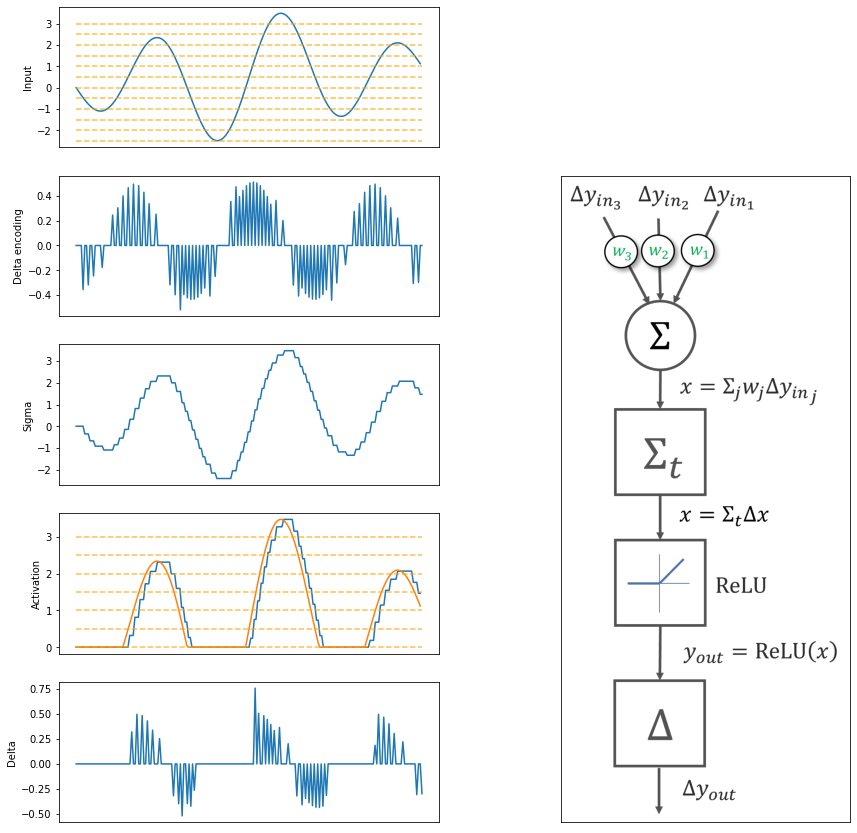

In [6]:
fig = plt.figure(figsize=(15, 15))

ax = plt.subplot2grid((5, 2), (0, 0))
ax.set_ylabel("Input")
ax.plot(inp_data[0])
ax.hlines(np.arange(np.min(inp_data) // vth, np.max(inp_data) // vth + 1) * vth, 0, t_sim, linestyle='--', alpha=0.7, color='orange')
ax.set_xticks([])

ax = plt.subplot2grid((5, 2), (1, 0))
ax.set_ylabel("Delta encoding")
ax.plot(delta_out)
ax.set_xticks([])

ax = plt.subplot2grid((5, 2), (2, 0))
ax.set_ylabel("Sigma")
ax.plot(neuron_sigma)
ax.set_xticks([])

ax = plt.subplot2grid((5, 2), (3, 0))
ax.set_ylabel("Activation")
ax.plot(neuron_act)
ax.plot(relu[0])
ax.hlines(np.arange(np.max(neuron_act) // vth + 1) * vth, 0, t_sim, linestyle='--', alpha=0.7, color='orange')
ax.set_xticks([])

ax = plt.subplot2grid((5, 2), (4, 0))
ax.set_ylabel("Delta")
ax.plot(neuron_out)
ax.set_xticks([])

ax = plt.subplot2grid((5, 2), (1, 1), rowspan=4)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(PIL.Image.open(urllib.request.urlopen("https://raw.githubusercontent.com/lava-nc/lava-docs/img/sig-delta-neuron/_static/images/tutorial10/sdn.png")));

## Computational costs 

Using the sigma-delta neuron the activation, and hence the computation cost, is drastically reduced after decoding the input signal. 

In [7]:
MACs = len(inp_data[0])
syn_ops = len(np.where(delta_out != 0)[0])

print(f"ANN MACs: {MACs}, Sigma-Delta SynOps: {syn_ops}, reduction: {int((1 - (syn_ops/MACs)) * 100)}%")

ANN MACs: 200, Sigma-Delta SynOps: 63, reduction: 68%


## How to learn more?

In order to learn more about the application of Sigma-Delta neurons, take a look at the tutorials about [training a spiking deep neural network](https://github.com/bamsumit/lava-dl/blob/main/tutorials/lava/lib/dl/slayer/pilotnet/train.ipynb) in [lava-dl](https://lava-nc.org/dl.html).

If you want to find out more about Lava, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation").

To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb).